# Cam-Scanner using OpenCV
Name: **Soham Bhattacharya** <br>
Reg. No.: **B2430059**

## Importing necessary packages

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# User defined printing method

def show(img, title="", cmap='gray', off=False):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    if off:
        plt.axis('off')
    plt.show()

In [3]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    # Sum and difference to order points
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]       # top-left
    rect[2] = pts[np.argmax(s)]       # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]    # top-right
    rect[3] = pts[np.argmax(diff)]    # bottom-left

    return rect

In [4]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Compute width of new image
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    # Compute height of new image
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    # Destination points
    dst = np.array([
        [0, 0],
        [maxWidth-1, 0],
        [maxWidth-1, maxHeight-1],
        [0, maxHeight-1]], dtype="float32")

    # Compute perspective transform matrix and apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

## Preprocessing

Text(0.5, 1.0, 'Original Image')

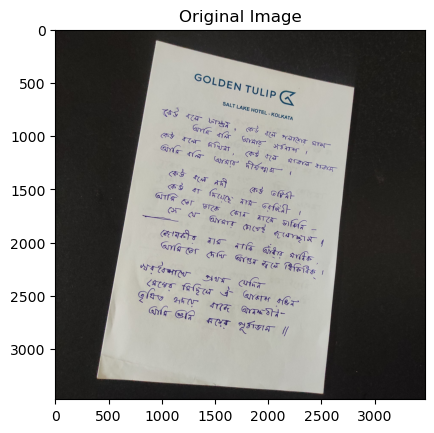

In [5]:
image = cv2.imread('data/test2.jpg')
orig = image.copy()


plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

Text(0.5, 1.0, 'Resized image')

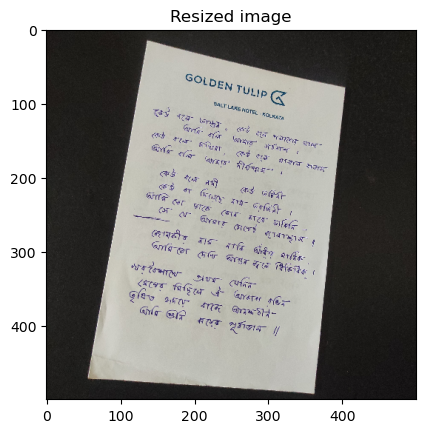

In [6]:
# Resizing image for faster processing
if image.shape[0]>1000.0:
    ratio = image.shape[0] / 500.0
    image = cv2.resize(image, (int(image.shape[1] / ratio), 500))


plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Resized image")

In [7]:
# Convert to grayscale and then gaussian blur
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

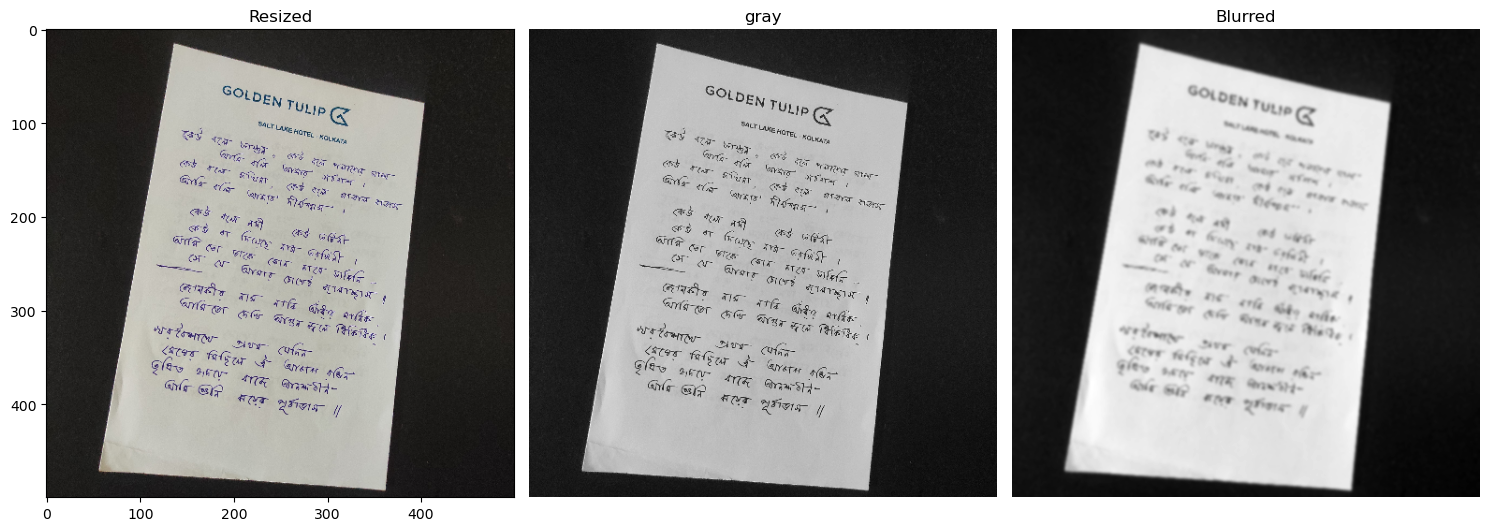

In [8]:
plt.figure(figsize=(15, 5))  # Width x Height in inches

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Resized')
# plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gray,cmap="gray")
plt.title('gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(blurred,cmap="gray")
plt.title('Blurred')
plt.axis('off')

plt.tight_layout()
plt.show()

## Edge Detection

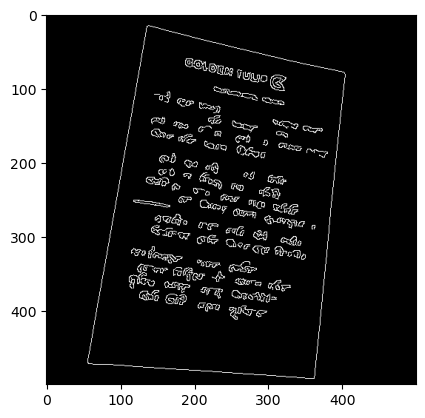

In [9]:
# edged = cv2.Canny(blurred, 75, 200)
edged = cv2.Canny(blurred, 30, 150)


plt.imshow(edged, cmap="gray")

## Contour Detection

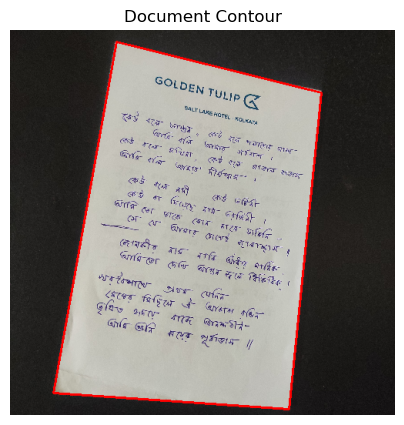

In [18]:
# Find contours
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

doc_cnts = None
final = None
# Loop over contours to find the document
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.09 * peri, True)

    if len(approx) == 4:
        doc_cnts = approx
        break

if doc_cnts is None:
    raise Exception("No document contour found! Try using a clearer image with visible document edges.")
else:
    # Draw and display contour
    cv2.drawContours(image, [doc_cnts], -1, (0, 0, 255), 2)
    show(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), "Document Contour", off=True)

## Perspective Transformation

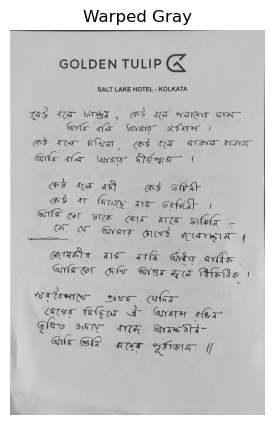

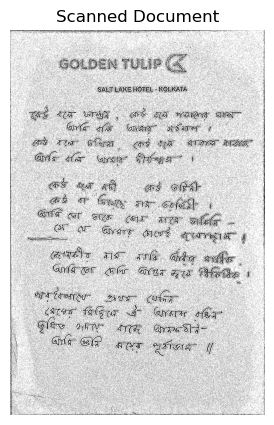

In [17]:
if doc_cnts is None:
    raise Exception("No document contour found! Try using a clearer image with visible document edges.")
else:
    # Apply perspective transform
    warped = four_point_transform(orig, doc_cnts.reshape(4, 2) * ratio)

    # Convert to grayscale and threshold to get scanned effect
    warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    show(warped_gray, "Warped Gray", off=True)
    scanned = cv2.adaptiveThreshold(warped_gray, 255, 
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY, 11, 2)
    
    final = scanned
    show(scanned, "Scanned Document", off=True)

## Output

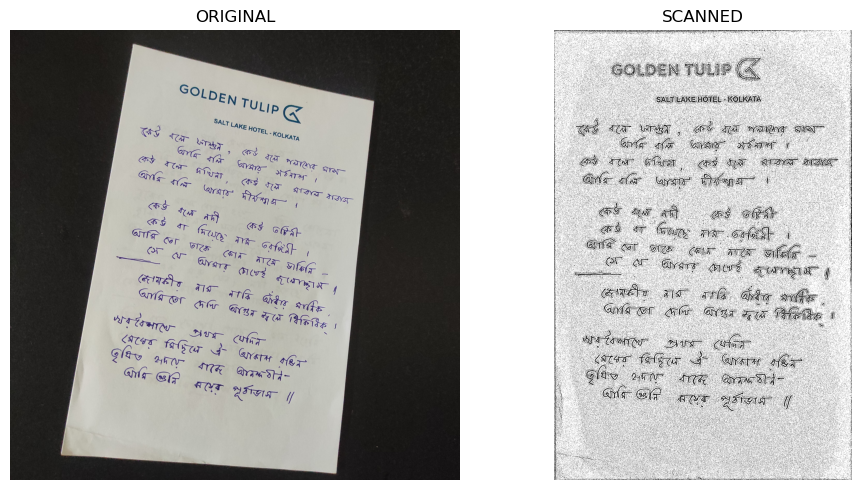

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title('ORIGINAL')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(final, cmap="gray")
plt.title('SCANNED')
plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
final.shape

(3217, 2129)

Text(0.5, 1.0, 'Scanned Document')

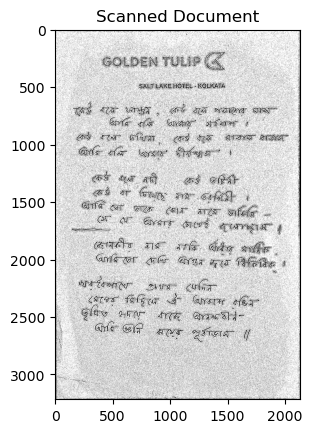

In [14]:
binary = cv2.adaptiveThreshold(final, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)
plt.imshow(binary, cmap="gray")
plt.title("Scanned Document")

In [15]:
np.unique(final)

array([  0, 255], dtype=uint8)

# THANK YOU